# Collaborative Filtering with Deep Learning (Neural CF)

A popular method of collaborative filtering used that leverages the power of deep learning in Neural Collaborative Filtering. This is a bit similar to Matrix Factorization, but with extra layers so in a mathematical sense is not Matrix Factorization anymore. The idea is to convert user and games into an embedding vector each of the same lenght, then scalar multiply these two vectors, follow by some fully connected layers, and then finally a logisitic node.

Using the matrix made in the third notebook, a deep learning model will be trained for proof of concept. Since this will not be fully productionized, it will be built with keras, the convient python framework for deep learning that can be backend by tensorflow.

Sources

[Functional API example](https://keras.io/guides/functional_api/) - Keras Documentation

[Article example](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401) - Article which guided this project for the most part. 

In [1]:
%matplotlib inline
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.special import expit
from timeit import default_timer


print("numpyy version: ",np.__version__)
print("tensorflow version: ", tf.__version__)
print("keras version: ", keras.__version__)

C:\Users\alexr\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\alexr\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\alexr\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


numpyy version:  1.18.5
tensorflow version:  2.3.0
keras version:  2.4.0


List available devices for tensorflow, to ensure GPU will be utilized (if you have one)

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

The spare matrix from the thrid notebook will be used for the Neural Collaborative filtering

In [3]:
dtype_dict_games = {'buyer-count': 'int64',
 'player-count': 'int64',
 'accumulated-hours-played': 'float64',
 'player-frac-of-buyer': 'float64',
 'avg-hours-played': 'float64',
 'std-hours-played': 'float64'}

dtype_dict_users = {'purchased-game-count': 'int64',
 'played-game-count': 'int32',
 'played-hours-count': 'float64',
 'purhased-gametitles-list': 'object',
 'played-gametitles-list': 'object',
 'percent-library-played': 'float64',
 'played-hours-avg': 'float64',
 'played-hours-std': 'float64',
 'played-hours-max': 'float64',
 'most-played-game': 'object'}

games_stats_df = pd.read_csv('./steam_game_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_games)
users_stats_df = pd.read_csv('./steam_user_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_users)


#names to assign to columns
column_names = ['user-id','game-title','behavior-name','value']

#dtypes to assign
dtypes = {'user-id':int, 'game-title':str, 'behavior-name':'category', 'value':np.float64}

#read in data from csv (please adjust path if you want to run this). Dropped last column because useless
df = pd.read_csv('./steam-200k.csv', 
                usecols=[0,1,2,3],
                names=column_names)

#selects only play data (not purchase data)
play_mask = df['behavior-name'] == 'play'
play_df = df[play_mask]

#turn the full game list into list object to feed functions later
full_game_list = games_stats_df.index.to_list()
full_user_list = users_stats_df.index.to_list()

#instanciate label encoder
le = LabelEncoder()

#fit and transform the list of user-ids
pseudo_users = le.fit_transform(full_user_list)

#Store mapping into diction and dump content into pkl
pseudo_user_map = dict(zip(pseudo_users, le.classes_))
with open('./user_encoding_dict.pkl', 'wb') as file:
    pickle.dump(pseudo_user_map, file)

#repeat for games encoding
pseudo_games = le.fit_transform(full_game_list)    
pseudo_game_map = dict(zip(pseudo_games, le.classes_))
with open('./game_encoding_dict.pkl', 'wb') as file:
    pickle.dump(pseudo_game_map, file)

games_played_matrix = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

for ind, row in play_df.iterrows():
    games_played_matrix.at[int(row['user-id']), row['game-title']] = 1

#the labels are changed after inputing the values
games_played_matrix.index = pseudo_users
games_played_matrix.columns = pseudo_games

for ind, row in games_played_matrix.iterrows():
    row.fillna(0, inplace=True)
    
games_played_matrix_sparse = sparse.dok_matrix(games_played_matrix.values)

To create the traning data and labels, this loop will create list of values from the matrix, and then randomly create 0 values for games a user hasn't played. This loop was adapted from [hexiangnan's github](https://github.com/hexiangnan/neural_collaborative_filtering)

In [4]:
user_input_data, game_input_data, labels_data = [],[],[]
num_users, num_games = games_played_matrix_sparse.shape
for (u, i) in games_played_matrix_sparse.keys():
    # positive instance
    user_input_data.append(float(u))
    game_input_data.append(float(i))
    labels_data.append(1.0)
    # negative instances, 4 choosen arbitrarily
    for t in range(4):
        j = np.random.randint(num_games)
        while games_played_matrix_sparse[u, j] == 1:
            j = np.random.randint(num_games)
        user_input_data.append(float(u))
        game_input_data.append(float(j))
        labels_data.append(0.0)

The games and items will be label encoded and the mapping will be stored inside a pkl file. The pseudo_users and pseudo_games will be input into the Input Layer of the model. These values will be fed into an embedding layer each as discussed before. After each embedding, to help avoid overfitting, we introduce a dropout layer. After the embedding layer, the vectors are flattend and multiplied elementwise (dot/scalar product). Afterwards, this new vector is fed into a fully connected(fc) dense layer, followed by another drop out layer. Finally, the fc layer is connected to a single node with a sigmoid function for an activation function. For this first model, the summary will be printed, followed by the diagram to help clarify the design.

In [5]:
#Constant parameters for model
latent_dim = 100
fc_dim = 50

#design input layer
user_input = keras.Input(shape = (1,), name="user")
game_input = keras.Input(shape = (1,), name="game")

#create embeddings for vector representing user and their games played
user_embeddings = layers.Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                  embeddings_initializer="uniform", input_length=1)(user_input)
game_embeddings = layers.Embedding(input_dim = num_games, output_dim = latent_dim, name = 'game_embedding',
                                  embeddings_initializer="uniform", input_length=1)(game_input)

#add dropout to both embedding layers
user_dropout = layers.Dropout(rate=.5, name='user_dropout')(user_embeddings)
game_dropout = layers.Dropout(rate=.5, name='game_dropout')(game_embeddings)

#flatten out results into one dimension
user_latent = layers.Flatten(name = "user_flatten")((user_dropout))
game_latent = layers.Flatten(name = "game_flatten")((game_dropout))

#dot product of these latent vectors
predict_vector = layers.Multiply(name = "dot_product")([user_latent, game_latent])

#one hidden fully connected layer after dot product
dense_layer = layers.Dense(fc_dim, name = "fully_connected", kernel_initializer = 'lecun_uniform', activation = 'relu')(predict_vector)

#dropout after fully connected to help against overfitting
dense_dropout = layers.Dropout(rate=.5, name = "fc_dropout")(dense_layer)

#final dense layer
prediction = layers.Dense(1, activation= 'sigmoid', kernel_initializer= 'lecun_uniform', name = 'predicition')(dense_dropout)

#Build the model
model = keras.Model(inputs = [user_input, game_input], outputs = prediction, name='Neural_CF')

#print summary
model.summary()

Model: "Neural_CF"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
game (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       1239300     user[0][0]                       
__________________________________________________________________________________________________
game_embedding (Embedding)      (None, 1, 100)       515500      game[0][0]                       
__________________________________________________________________________________________

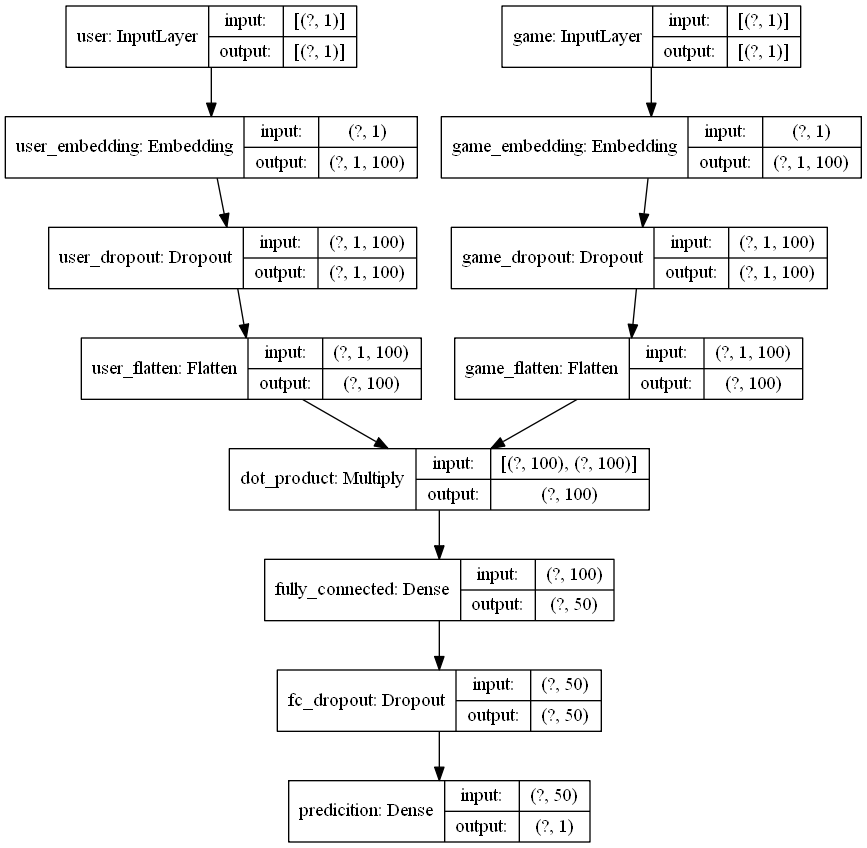

In [6]:
keras.utils.plot_model(model, "Neural CF.png", show_shapes=True)

The next step is to split up the data set into training and testing data. Personally I think 1/5 or 1/3 splits are pretty appropriate. When this was first written, I didn't understand the input for the train_test_split function, so I designed this zipping first before splitting. In retrospect, feeding the three lists would have worked by return 6 "split" lists (2 per list). It actually doesn't care about the second input being a label or not.

In [7]:
from sklearn.model_selection import train_test_split
#zip user and game features together to allow train_test_split to split into training and testing data
user_game_input_data = list(zip(user_input_data, game_input_data))

#apply split
X_train, X_test, Y_train, Y_test = train_test_split(user_game_input_data, labels_data, test_size=0.2, random_state=42)

#split each X_train and X_test into user and game inputs again
user_train_input, game_train_input = map(list, zip(*X_train))
user_test_input, game_test_input = map(list, zip(*X_test))

To train the model, first it must be compiled, which comes with a few decisions. First, the loss function; this is the function that should be minimized (or maximized depending on fuction used) to improve performance. The driving reason for define the loss function and not using normal evaluation metrics is because deep learning uses calculus to decide how to adjust parameters. To use calculus, (specifically the derivative operater) the function has to be continous (along with other conditions I won't bring up now), which a discrete function like accuracy won't have. However, since the loss function is used to drive the change, a metric still needs to be defined so the human can interpret and validate the results quantatatively. Finally, the algorithm for making parameter adjustments is known as the optimizer. Unless there's a strong reason to believe a specific optimizer would be ideal for your situation, it's best to use the lastest "state-of-the-art" optimizer, which at the time of writing this notebook, was the ADAM optimizer.

A manually loop was written for the epoch training (epoch = 1 iteration of all the training data), so that the test evaluation scores could be manually collected and graphed.

2203/2203 [==============================] - 1s 439us/step - loss: 0.2976 - accuracy: 0.8929


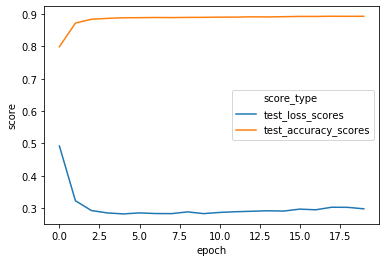

In [8]:
#Setting the training hyperparameters for the model
model.compile(loss='binary_crossentropy', 
              optimizer = 'adam',
              metrics = ["accuracy"])

#Training Parameters
epochs = 20  #number of iteration to run all the data through
batch_size = 100
split = 0.2

test_loss_scores = []
test_accuracy_scores = []
#Train the model
for epoch in range(epochs):
    model.fit([np.array(user_train_input), np.array(game_train_input)],
              np.array(Y_train),
              batch_size = batch_size,
              epochs = 1,
              validation_split = split)
    
    test_scores = model.evaluate([np.array(user_test_input), np.array(game_test_input)], np.array(Y_test))
    test_loss_scores.append(test_scores[0])
    test_accuracy_scores.append(test_scores[1])
    
training_scores_df = pd.DataFrame([test_loss_scores, test_accuracy_scores], index = ['test_loss_scores', 'test_accuracy_scores']).T
training_scores_df['epoch'] = training_scores_df.index

training_scores_df = pd.melt(training_scores_df, id_vars= 'epoch',
        value_vars = ['test_loss_scores', 'test_accuracy_scores'],
        var_name = 'score_type',
        value_name = 'score')

sns.lineplot(x= 'epoch', y= 'score', hue = 'score_type', data = training_scores_df )

Looking at the results, it appears that we may have overfitted, but nothing significantly bad. The loss function reaches its minimum after about 3 epochs, but doesn't raise much after, and the accuracy reaches above 85%. This is about 5% more accurate than the dummy predictor (always choosing the most common class, 0.0, which is 80% of the labels). Because it's good to be able to redo the same model with small adjustment, the code will be turned into a function now for creating and training the model.

In [9]:
def get_model(name = "", latent_dim = 100, fc_dim = 50):
    #Constant parameters for model
    model_name = "Neural_CF_" + name
    latent_dim = 100
    fc_dim = 50

    #design input layer
    user_input = keras.Input(shape = (1,), name="user")
    game_input = keras.Input(shape = (1,), name="game")

    #create embeddings for vector representing user and their games played
    user_embeddings = layers.Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                  embeddings_initializer="uniform", input_length=1)(user_input)
    game_embeddings = layers.Embedding(input_dim = num_games, output_dim = latent_dim, name = 'game_embedding',
                                  embeddings_initializer="uniform", input_length=1)(game_input)

    #add dropout to both embedding layers
    user_dropout = layers.Dropout(rate=.5, name='user_dropout')(user_embeddings)
    game_dropout = layers.Dropout(rate=.5, name='game_dropout')(game_embeddings)

    #flatten out results into one dimension
    user_latent = layers.Flatten(name = "user_flatten")((user_dropout))
    game_latent = layers.Flatten(name = "game_flatten")((game_dropout))

    #dot product of these latent vectors
    predict_vector = layers.Multiply(name = "dot_product")([user_latent, game_latent])

    #one hidden fully connected layer after dot product
    dense_layer = layers.Dense(fc_dim, name = "fully_connected", kernel_initializer = 'lecun_uniform', activation = 'relu')(predict_vector)

    #dropout after fully connected to help against overfitting
    dense_dropout = layers.Dropout(rate=.5, name = "fc_dropout")(dense_layer)

    #final dense layer
    prediction = layers.Dense(1, activation= 'sigmoid', kernel_initializer= 'lecun_uniform', name = 'predicition')(dense_dropout)

    #Build the model
    model = keras.Model(inputs = [user_input, game_input], outputs = prediction, name=model_name)
    
    return model

def train_model(model, batch_size = 100, epochs = 20, split = 0.2, verbose=1):
    #Setting the training hyperparameters for the model
    model.compile(loss='binary_crossentropy', 
                  optimizer = 'adam',
                  metrics = ["accuracy"])

    test_loss_scores = []
    test_accuracy_scores = []
    #Train the model
    for epoch in range(epochs):
        model.fit([np.array(user_train_input), np.array(game_train_input)],
                  np.array(Y_train),
                  batch_size = batch_size,
                  epochs = 1,
                  validation_split = split,
                  verbose = verbose)

        test_scores = model.evaluate([np.array(user_test_input), np.array(game_test_input)], np.array(Y_test), verbose = verbose)
        test_loss_scores.append(test_scores[0])
        test_accuracy_scores.append(test_scores[1])

    training_scores_df = pd.DataFrame([test_loss_scores, test_accuracy_scores], index = ['test_loss_scores', 'test_accuracy_scores']).T
    training_scores_df['epoch'] = training_scores_df.index

    training_scores_df = pd.melt(training_scores_df, id_vars= 'epoch',
            value_vars = ['test_loss_scores', 'test_accuracy_scores'],
            var_name = 'score_type',
            value_name = 'score')

    sns.lineplot(x= 'epoch', y= 'score', hue = 'score_type', data = training_scores_df )
    
    return training_scores_df

Now the function defined above will be used to test out training with different batch sizes. 50, 100, 500, and 1000 will be used. The time of execution will also be recorded

In [10]:
def printScoresTime(scores_df, start_time):
    
    #measure time difference and print
    time_elapse = default_timer() - start_time
    print("Training this model took ", time_elapse, " second(s)")
    
    #collect highest accurcy and lowest loss
    best_loss = scores_df['score'].min()
    best_accuracy = scores_df['score'].max()
    print("With the best loss score being: ", best_loss)
    print("With the best accuracy score being: ", best_accuracy)

Training this model took  1470.8070521  second(s)
With the best loss score being:  0.28396934270858765
With the best accuracy score being:  0.8902904391288757


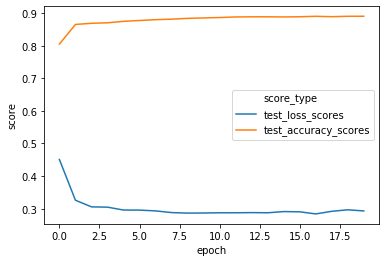

In [11]:
start_time = default_timer()

model_50 = get_model("BatchSize50")
keras.utils.plot_model(model_50, "Neural CF.png", show_shapes=True)
scores_df = train_model(model_50, batch_size = 50, verbose = 0)

printScoresTime(scores_df, start_time)

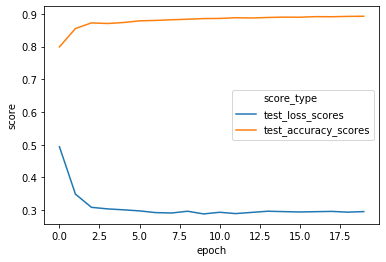

In [12]:
model_100 = get_model("BatchSize100")
scores_df = train_model(model_100, batch_size = 100, verbose = 0)

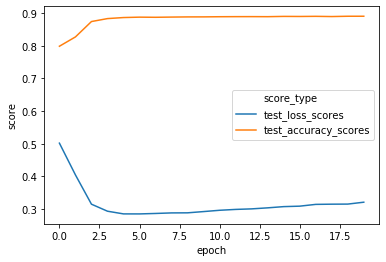

In [13]:
model_500 = get_model("BatchSize500")
scores_df = train_model(model_500, batch_size = 500, verbose = 0)

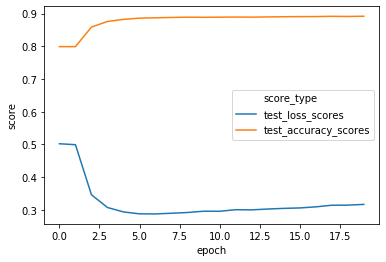

In [14]:
model_1000 = get_model("BatchSize1000")
scores_df = train_model(model_1000, batch_size = 1000, verbose = 0)

The results show that training with a smaller batch size not only converged to its minimum loss faster, but also was more robust to overfitting (loss increase less after trough).

To attempt to check the quality of the results, a quick test will be preformed. 

Using one of the aggregate tables generated before, there are plenty of user-game pairs of user's most played game. Although the recommender shouldn't necessarily output 1 for all games in the play_df dataframe because its not unthinkable for someone to play a game they usually wouldn't, but their most played game should likely be "recommended".

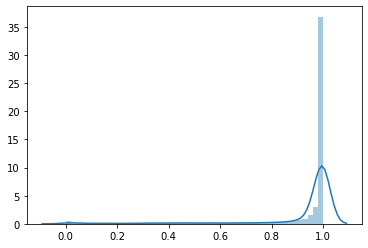

In [15]:
#the reverse mapping is defined from before to make it easy to transform the information
pseudo_user_map_r = {value:key for key, value in pseudo_user_map.items()}
pseudo_game_map_r = {value:key for key, value in pseudo_game_map.items()}

#create series of users and their fav game, filtering out NaNs. Then making lists from index and values
user_favGame_pair = users_stats_df[users_stats_df['most-played-game'].notna()]['most-played-game']
fav_users = user_favGame_pair.index.to_list()
fav_games = list(user_favGame_pair.values)

#using mapping created before from encoder
input_fav_users = np.array([pseudo_user_map_r[x] for x in fav_users])
input_fav_games = np.array([pseudo_game_map_r[x] for x in fav_games])

#find prediction for all user-game pairs. Put resulting scores in series
AreFavoriteGamesRecommended = pd.Series(model.predict([input_fav_users, input_fav_games]).flatten())
AreFavoriteGamesRecommended.describe()

#plot distribution of series using sns.distplot
sns.distplot(AreFavoriteGamesRecommended)

The vast majority of predicitons cam back near 1, which does give some reassurance that these embeddings were able to capture some of similarities between games and users.

Just as an exercise, a recommendation vector will be created for one user. There's no strong reason to create it for all users.

I "randomly" selected user 76767 due to having a substantial amount of play time.

In [16]:
#create array of the user's encoded labels copied over the number of games total
user_array = pseudo_user_map_r[76767]*np.ones(len(pseudo_games))

#run model with this array and pseudo_games. Flatten result and stick in pandas Series
recommendations = pd.Series(model.predict([user_array, np.array(pseudo_games)]).flatten())

#change index to game titles
recommendations.index = [pseudo_game_map[x] for x in recommendations.index.to_list()]

recommendations.sort_values(ascending=False).head(10)

Team Fortress 2                                0.999911
Dota 2                                         0.998712
Counter-Strike                                 0.998378
Left 4 Dead 2                                  0.995382
Counter-Strike Global Offensive                0.994255
Counter-Strike Source                          0.994036
Half-Life 2                                    0.992124
The Elder Scrolls V Skyrim                     0.990732
Portal                                         0.986966
Call of Duty Modern Warfare 2 - Multiplayer    0.982263
dtype: float32

The results are reasonable. This seems like the type of person who likes playing mainstream multiplayer games, but spending heavy hours on them, but also interested in valve games.